In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import copy
import sys
import os
from pylab import *
import copy
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d

In [2]:
def preprocess(data):
    zeros = np.zeros_like(data)
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
   
    std[std == 0] = 1  # Avoid division by zero by setting std to 1 where it is 0
    zeros = (data - mean) / std
    return zeros


def smooth_with_gaussian(data, sigma=2):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

In [3]:
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {cl: 
                  {cr: [] for cr in classes_right}
                    for cl in classes_left
                } 

l_al_data = copy.deepcopy(agg_structure)
r_al_data = copy.deepcopy(agg_structure)
a_al_data = copy.deepcopy(agg_structure)

l_ar_data = copy.deepcopy(agg_structure)
r_ar_data = copy.deepcopy(agg_structure)
a_ar_data = copy.deepcopy(agg_structure)


n_values = {cl:
             {cr: {
                'attleft': [],
                'attright': []
                } for cr in classes_right} for cl in classes_left} 

#loading the data by class combinations
total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]

    
    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]

    sigma = 2

    left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
    right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
    att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80
                
    for j in range(0, num_trials):
        for i in range(0, num_neurons):
            count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
            if count_left > 0:
                left_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
            if count_right > 0:
                right_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
            if count_attention > 0:
                att_sm[j, :, i] /= count_attention


    left_input_SP = np.sum(left_sm, axis=2)
    right_input_SP = np.sum(right_sm, axis=2)
    attention_SP = np.sum(att_sm, axis=2)

    #preprocess here now that we have traces of all of the relavant trials
    left_input_SP = preprocess(left_input_SP)
    right_input_SP = preprocess(right_input_SP)
    attention_SP = preprocess(attention_SP)

    #so now for each dataset we have a preprocessed set of LFP like signals
    for cl in classes_left:
         for cr in classes_right: 
    
            left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left == cl) & (label_right == cr))[0]
            left_indices = np.where(np.isin(relevant, left_indices_agg))[0]
            right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left == cl) & (label_right == cr))[0]
            right_indices = np.where(np.isin(relevant, right_indices_agg))[0]

            n_values[cl][cr][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[cl][cr][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty
          
            if len(left_indices) >= 1: 
                l_al = left_input_SP[left_indices, 100:350]
                r_al = right_input_SP[left_indices, 100:350]
                a_al = attention_SP[left_indices, 100:350] 


                l_al_data[cl][cr].append(l_al)
                r_al_data[cl][cr].append(r_al)
                a_al_data[cl][cr].append(a_al)


            if len(right_indices) >= 1:
                l_ar = left_input_SP[right_indices, 100:350]
                r_ar = right_input_SP[right_indices, 100:350]
                a_ar = attention_SP[right_indices, 100:350]

            
                l_ar_data[cl][cr].append(l_ar)   
                r_ar_data[cl][cr].append(r_ar)
                a_ar_data[cl][cr].append(a_ar)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")


#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')


Dataset 1 loaded in 22.55 seconds
Dataset 1 processed in 12.84 seconds
Dataset 2 loaded in 17.93 seconds
Dataset 2 processed in 10.67 seconds
Dataset 4 loaded in 25.91 seconds
Dataset 4 processed in 22.20 seconds
Dataset 8 loaded in 14.32 seconds
Dataset 8 processed in 12.49 seconds
Dataset 14 loaded in 20.78 seconds
Dataset 14 processed in 22.50 seconds
Dataset 15 loaded in 21.38 seconds
Dataset 15 processed in 23.48 seconds
Dataset 20 loaded in 17.29 seconds
Dataset 20 processed in 23.39 seconds
Dataset 23 loaded in 23.90 seconds
Dataset 23 processed in 46.27 seconds
Total load time = 338.46 seconds


In [4]:
for cl in classes_left:
    for cr in classes_right:
        if len(l_al_data[cl][cr]) > 0:
            l_al_data[cl][cr] = np.concatenate(l_al_data[cl][cr], axis = 0)
            r_al_data[cl][cr] = np.concatenate(r_al_data[cl][cr], axis = 0)
            a_al_data[cl][cr] = np.concatenate(a_al_data[cl][cr], axis = 0)

            l_ar_data[cl][cr] = np.concatenate(l_ar_data[cl][cr], axis = 0)
            r_ar_data[cl][cr] = np.concatenate(r_ar_data[cl][cr], axis = 0)
            a_ar_data[cl][cr] = np.concatenate(a_ar_data[cl][cr], axis = 0)
            

        else:
            print(f"No data for class left {cl} and class right {cr}.")


##-----------------calculating the number of trials for each class pair----------------
n_values_sum = {cl: {cr: {'attleft': 0, 'attright': 0} for cr in classes_right} for cl in classes_left}


for cl in classes_left:
    for cr in classes_right:
        n_values_sum[cl][cr]['attleft'] = len(l_al_data[cl][cr]) 
        n_values_sum[cl][cr]['attright'] = len(l_ar_data[cl][cr]) 
        

In [39]:
#-------------pearson calculation----------------
lr_split_structure = {cl: {cr: {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for cr in classes_right} for cl in classes_left}

pearson_values = copy.deepcopy(lr_split_structure)
pearson_stdevs = copy.deepcopy(lr_split_structure)

run_time = time.time()
for cl in classes_left:
    coh_start = time.time()
    for cr in classes_right: 

        if n_values_sum[cl][cr]['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue                    
        
        for i in range(len(l_al_data[cl][cr])):
            pearson_values[cl][cr]['left_attleft'].append(pearsonr(l_al_data[cl][cr][i], a_al_data[cl][cr][i])[0])
            pearson_values[cl][cr]['right_attleft'].append(pearsonr(r_al_data[cl][cr][i], a_al_data[cl][cr][i])[0])

    

for cl in classes_left:
    for cr in classes_right: 
        if n_values_sum[cl][cr]['attright'] == 0:  #right class pairs that have trials
            print(f"[SKIP] {cl}-{cr}: no attleft trials")
            continue    

        for i in range(len(l_ar_data[cl][cr])):
            pearson_values[cl][cr]['left_attright'].append(pearsonr(l_ar_data[cl][cr][i], a_ar_data[cl][cr][i])[0])
            pearson_values[cl][cr]['right_attright'].append(pearsonr(r_ar_data[cl][cr][i], a_ar_data[cl][cr][i])[0])    

    print(f"Class pair {cl} {cr} processed in {time.time() - coh_start:.2f} seconds")
         
run_time = time.time() - run_time
print(f"Total run time: {run_time:.2f} seconds")

pearson_values_2 = copy.deepcopy(pearson_values)
pearson_stdev_2 = copy.deepcopy(pearson_stdevs)


run_time = time.time()
for cl in classes_left:
    coh_start = time.time()
    for cr in classes_right: 

        if n_values_sum[cl][cr]['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue                    
        
        for i in range(2):
            pearson_values_2[cl][cr]['left_attleft'].append(pearsonr(l_al_data[cl][cr][i], a_al_data[cl][cr][i])[0])
            pearson_values_2[cl][cr]['right_attleft'].append(pearsonr(r_al_data[cl][cr][i], a_al_data[cl][cr][i])[0])
            if cl == 0 and cr ==0:
                print('trial')

    

for cl in classes_left:
    for cr in classes_right: 
        if n_values_sum[cl][cr]['attright'] == 0:  #right class pairs that have trials
            print(f"[SKIP] {cl}-{cr}: no attleft trials")
            continue    

        for i in range(2):
            pearson_values_2[cl][cr]['left_attright'].append(pearsonr(l_ar_data[cl][cr][i], a_ar_data[cl][cr][i])[0])
            pearson_values_2[cl][cr]['right_attright'].append(pearsonr(r_ar_data[cl][cr][i], a_ar_data[cl][cr][i])[0])    

    print(f"Class pair {cl} {cr} processed in {time.time() - coh_start:.2f} seconds")
         
run_time = time.time() - run_time
print(f"Total run time: {run_time:.2f} seconds")



Class pair 0 19 processed in 0.23 seconds
Class pair 1 19 processed in 0.39 seconds
Class pair 2 19 processed in 0.54 seconds
Class pair 3 19 processed in 0.71 seconds
Class pair 4 19 processed in 0.90 seconds
Class pair 5 19 processed in 1.04 seconds
Class pair 6 19 processed in 1.16 seconds
Class pair 7 19 processed in 1.33 seconds
Class pair 8 19 processed in 1.49 seconds
Class pair 9 19 processed in 1.62 seconds
Class pair 10 19 processed in 1.77 seconds
Class pair 11 19 processed in 1.93 seconds
Class pair 12 19 processed in 2.12 seconds
Class pair 13 19 processed in 2.28 seconds
Class pair 14 19 processed in 2.44 seconds
Class pair 15 19 processed in 2.60 seconds
Class pair 16 19 processed in 2.79 seconds
Class pair 17 19 processed in 2.96 seconds
Class pair 18 19 processed in 3.12 seconds
Class pair 19 19 processed in 3.29 seconds
Total run time: 7.34 seconds
trial
trial
Class pair 0 19 processed in 0.05 seconds
Class pair 1 19 processed in 0.07 seconds
Class pair 2 19 processed

In [40]:
results_to_plot = copy.deepcopy(lr_split_structure)

for cl in classes_left:
    for cr in classes_right:
        for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
            results_to_plot[cl][cr][key] = np.mean(pearson_values[cl][cr][key])

lowest_classes =  [(np.int64(12), np.int64(18)), (np.int64(18), np.int64(12)), (np.int64(7), np.int64(18)), (np.int64(14), np.int64(18)), (np.int64(18), np.int64(7)), (np.int64(12), np.int64(8)), (np.int64(8), np.int64(12)), (np.int64(7), np.int64(8)), (np.int64(8), np.int64(7)), (np.int64(18), np.int64(15)), (np.int64(16), np.int64(12)), (np.int64(18), np.int64(14)), (np.int64(6), np.int64(18)), (np.int64(15), np.int64(18)), (np.int64(8), np.int64(14)), (np.int64(11), np.int64(7)), (np.int64(17), np.int64(18)), (np.int64(7), np.int64(11)), (np.int64(16), np.int64(7)), (np.int64(3), np.int64(12)), (np.int64(11), np.int64(12)), (np.int64(18), np.int64(17)), (np.int64(18), np.int64(6)), (np.int64(12), np.int64(10)), (np.int64(12), np.int64(11)), (np.int64(0), np.int64(18)), (np.int64(18), np.int64(2)), (np.int64(7), np.int64(10)), (np.int64(7), np.int64(16)), (np.int64(2), np.int64(18)), (np.int64(18), np.int64(0)), (np.int64(12), np.int64(6)), (np.int64(7), np.int64(1)), (np.int64(6), np.int64(8)), (np.int64(12), np.int64(16)), (np.int64(12), np.int64(1)), (np.int64(7), np.int64(19)), (np.int64(17), np.int64(8)), (np.int64(10), np.int64(7)), (np.int64(18), np.int64(13)), (np.int64(6), np.int64(12)), (np.int64(12), np.int64(19)), (np.int64(19), np.int64(12)), (np.int64(12), np.int64(5)), (np.int64(9), np.int64(12)), (np.int64(4), np.int64(18)), (np.int64(10), np.int64(12)), (np.int64(18), np.int64(4)), (np.int64(6), np.int64(17)), (np.int64(8), np.int64(17)), (np.int64(16), np.int64(17)), (np.int64(16), np.int64(15)), (np.int64(8), np.int64(6)), (np.int64(7), np.int64(9)), (np.int64(7), np.int64(5)), (np.int64(17), np.int64(6)), (np.int64(17), np.int64(16)), (np.int64(11), np.int64(14)), (np.int64(18), np.int64(5)), (np.int64(7), np.int64(6)), (np.int64(6), np.int64(10)), (np.int64(13), np.int64(18)), (np.int64(14), np.int64(8)), (np.int64(18), np.int64(3)), (np.int64(8), np.int64(0)), (np.int64(6), np.int64(5)), (np.int64(1), np.int64(7)), (np.int64(15), np.int64(8)), (np.int64(16), np.int64(14)), (np.int64(0), np.int64(8)), (np.int64(8), np.int64(2)), (np.int64(1), np.int64(12)), (np.int64(12), np.int64(3)), (np.int64(16), np.int64(0)), (np.int64(19), np.int64(7)), (np.int64(19), np.int64(6)), (np.int64(5), np.int64(7)), (np.int64(3), np.int64(7)), (np.int64(19), np.int64(17)), (np.int64(9), np.int64(7)), (np.int64(12), np.int64(9)), (np.int64(6), np.int64(13)), (np.int64(12), np.int64(4)), (np.int64(7), np.int64(3)), (np.int64(6), np.int64(9)), (np.int64(9), np.int64(6)), (np.int64(13), np.int64(6)), (np.int64(15), np.int64(17)), (np.int64(10), np.int64(6)), (np.int64(8), np.int64(4)), (np.int64(11), np.int64(6)), (np.int64(6), np.int64(11)), (np.int64(6), np.int64(1)), (np.int64(5), np.int64(6)), (np.int64(1), np.int64(6)), (np.int64(14), np.int64(16)), (np.int64(15), np.int64(0)), (np.int64(6), np.int64(0)), (np.int64(17), np.int64(15)), (np.int64(5), np.int64(18)), (np.int64(6), np.int64(14)), (np.int64(4), np.int64(6)), (np.int64(14), np.int64(11)), (np.int64(13), np.int64(8)), (np.int64(7), np.int64(15)), (np.int64(14), np.int64(6)), (np.int64(10), np.int64(14)), (np.int64(7), np.int64(2)), (np.int64(14), np.int64(10)), (np.int64(13), np.int64(16)), (np.int64(1), np.int64(14)), (np.int64(17), np.int64(11)), (np.int64(17), np.int64(10)), (np.int64(3), np.int64(6)), (np.int64(8), np.int64(13)), (np.int64(11), np.int64(17)), (np.int64(0), np.int64(1)), (np.int64(6), np.int64(7)), (np.int64(18), np.int64(16)), (np.int64(11), np.int64(15)), (np.int64(2), np.int64(6)), (np.int64(3), np.int64(18)), (np.int64(6), np.int64(15)), (np.int64(4), np.int64(12)), (np.int64(11), np.int64(0)), (np.int64(0), np.int64(6)), (np.int64(6), np.int64(4)), (np.int64(6), np.int64(19)), (np.int64(4), np.int64(8)), (np.int64(0), np.int64(3)), (np.int64(15), np.int64(12)), (np.int64(0), np.int64(16)), (np.int64(6), np.int64(3)), (np.int64(1), np.int64(15)), (np.int64(3), np.int64(2)), (np.int64(16), np.int64(3)), (np.int64(16), np.int64(4)), (np.int64(17), np.int64(2)), (np.int64(0), np.int64(11)), (np.int64(5), np.int64(12)), (np.int64(15), np.int64(6)), (np.int64(5), np.int64(17)), (np.int64(13), np.int64(15)), (np.int64(11), np.int64(4)), (np.int64(4), np.int64(10)), (np.int64(12), np.int64(2)), (np.int64(15), np.int64(7)), (np.int64(8), np.int64(5)), (np.int64(2), np.int64(8)), (np.int64(15), np.int64(5)), (np.int64(5), np.int64(14)), (np.int64(15), np.int64(9)), (np.int64(2), np.int64(16)), (np.int64(15), np.int64(13)), (np.int64(4), np.int64(15)), (np.int64(17), np.int64(19)), (np.int64(15), np.int64(1)), (np.int64(15), np.int64(16)), (np.int64(14), np.int64(1)), (np.int64(9), np.int64(15)), (np.int64(16), np.int64(18)), (np.int64(12), np.int64(15)), (np.int64(14), np.int64(5)), (np.int64(14), np.int64(19)), (np.int64(11), np.int64(5)), (np.int64(13), np.int64(12)), (np.int64(14), np.int64(9)), (np.int64(7), np.int64(4)), (np.int64(16), np.int64(2)), (np.int64(4), np.int64(16)), (np.int64(17), np.int64(3)), (np.int64(15), np.int64(11)), (np.int64(2), np.int64(17)), (np.int64(3), np.int64(17)), (np.int64(16), np.int64(13)), (np.int64(0), np.int64(19)), (np.int64(0), np.int64(10)), (np.int64(14), np.int64(4)), (np.int64(16), np.int64(6)), (np.int64(3), np.int64(15)), (np.int64(5), np.int64(11)), (np.int64(13), np.int64(11)), (np.int64(5), np.int64(10)), (np.int64(6), np.int64(16)), (np.int64(9), np.int64(4)), (np.int64(4), np.int64(14)), (np.int64(4), np.int64(3)), (np.int64(17), np.int64(5)), (np.int64(15), np.int64(3)), (np.int64(6), np.int64(6)), (np.int64(14), np.int64(2)), (np.int64(10), np.int64(17)), (np.int64(8), np.int64(15)), (np.int64(14), np.int64(3)), (np.int64(14), np.int64(0)), (np.int64(14), np.int64(7)), (np.int64(7), np.int64(17)), (np.int64(19), np.int64(0)), (np.int64(3), np.int64(14)), (np.int64(3), np.int64(3))]
results_to_plot_low = copy.deepcopy(lr_split_structure)



for cl in classes_left:
    for cr in classes_right:
        if (cl, cr) in lowest_classes:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot_low[cl][cr][key] = np.mean(pearson_values[cl][cr][key])
        else:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot_low[cl][cr][key] = -1

results_to_plot_2 = copy.deepcopy(lr_split_structure)

for cl in classes_left:
    for cr in classes_right:
        for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
            results_to_plot_2[cl][cr][key] = np.mean(pearson_values_2[cl][cr][key])

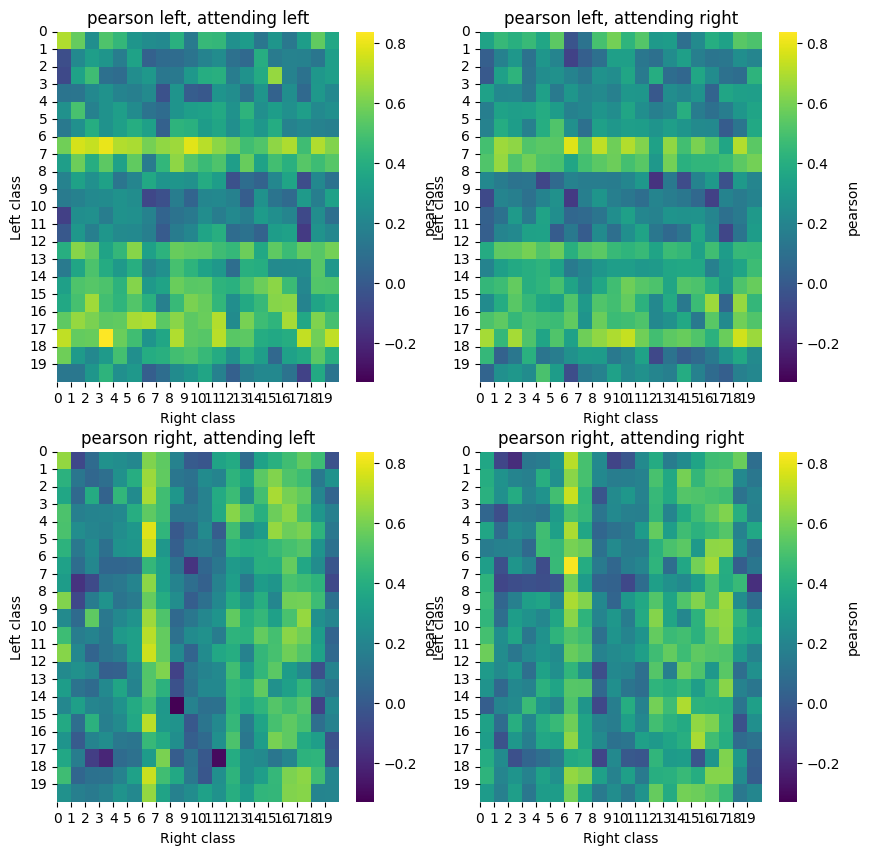

In [9]:
#==============================plotting heatmaps================================
def calculate_vmin_vmax(results_to_plot, classes_left, classes_right):
    vmax = np.max([results_to_plot[cl][cr][key] 
                   for cl in classes_left for cr in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    vmin = np.min([results_to_plot[cl][cr][key] 
                   for cl in classes_left for cr in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    return vmin, vmax


vmin, vmax = calculate_vmin_vmax(results_to_plot, classes_left, classes_right)



fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(np.array([[results_to_plot[cl][cr]['left_attleft'] for cr in classes_right] for cl in classes_left]), ax=ax[0, 0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,0].set_xticks(np.arange(0, 20))
ax[0,0].set_yticks(np.arange(0, 20))
ax[0,0].set_xticklabels(classes_right)
ax[0,0].set_yticklabels(classes_left)
ax[0,0].set_xlabel('Right class')
ax[0,0].set_ylabel('Left class')
ax[0,0].set_title(f'pearson left, attending left')

sns.heatmap(np.array([[results_to_plot[cl][cr]['right_attleft'] for cr in classes_right] for cl in classes_left]), ax=ax[1,0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,0].set_xticks(np.arange(0, 20))
ax[1,0].set_yticks(np.arange(0, 20))
ax[1,0].set_xticklabels(classes_right)
ax[1,0].set_yticklabels(classes_left)
ax[1,0].set_xlabel('Right class')
ax[1,0].set_ylabel('Left class')
ax[1,0].set_title(f'pearson right, attending left')

sns.heatmap(np.array([[results_to_plot[cl][cr]['left_attright'] for cr in classes_right] for cl in classes_left]), ax=ax[0,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,1].set_xticks(np.arange(0, 20))
ax[0,1].set_yticks(np.arange(0, 20))
ax[0,1].set_xticklabels(classes_right)
ax[0,1].set_yticklabels(classes_left)
ax[0,1].set_xlabel('Right class')
ax[0,1].set_ylabel('Left class')
ax[0,1].set_title(f'pearson left, attending right')

sns.heatmap(np.array([[results_to_plot[cl][cr]['right_attright'] for cr in classes_right] for cl in classes_left]), ax=ax[1,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,1].set_xticks(np.arange(0, 20))
ax[1,1].set_yticks(np.arange(0, 20))
ax[1,1].set_xticklabels(classes_right)
ax[1,1].set_yticklabels(classes_left)
ax[1,1].set_xlabel('Right class')
ax[1,1].set_ylabel('Left class')
ax[1,1].set_title(f'pearson right, attending right')

plt.show()


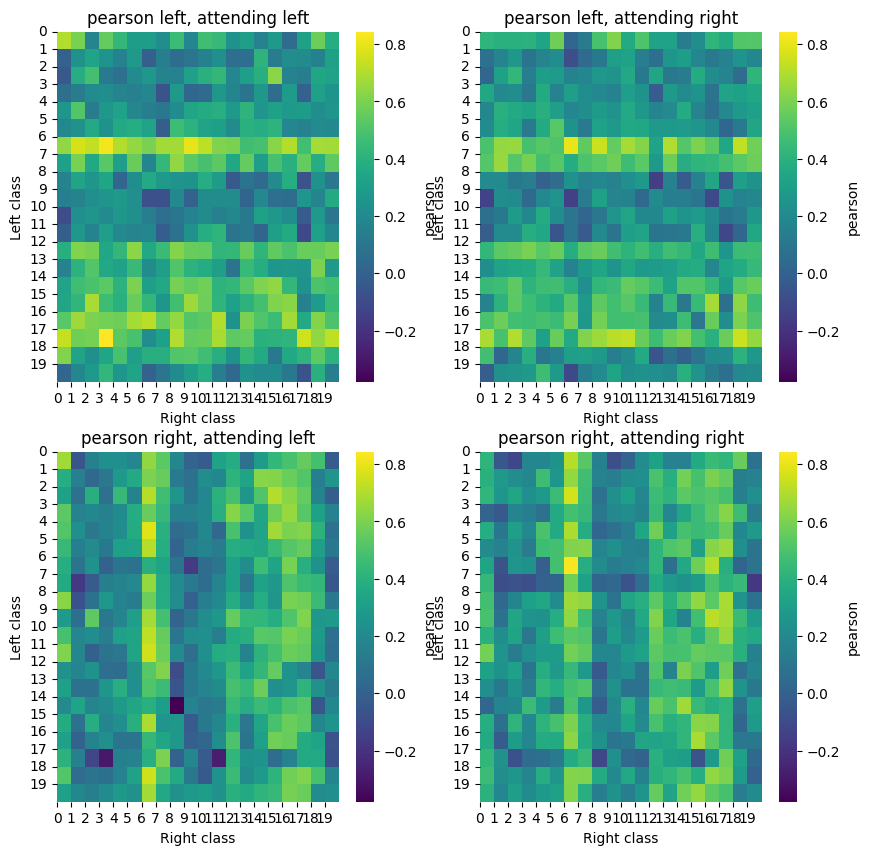

In [41]:
#==============================plotting heatmaps================================
def calculate_vmin_vmax(results_to_plot_2, classes_left, classes_right):
    vmax = np.max([results_to_plot_2[cl][cr][key] 
                   for cl in classes_left for cr in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    vmin = np.min([results_to_plot_2[cl][cr][key] 
                   for cl in classes_left for cr in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    return vmin, vmax


vmin, vmax = calculate_vmin_vmax(results_to_plot_2, classes_left, classes_right)



fig, ax = plt.subplots(2, 2, figsize=(10, 10))
sns.heatmap(np.array([[results_to_plot_2[cl][cr]['left_attleft'] for cr in classes_right] for cl in classes_left]), ax=ax[0, 0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,0].set_xticks(np.arange(0, 20))
ax[0,0].set_yticks(np.arange(0, 20))
ax[0,0].set_xticklabels(classes_right)
ax[0,0].set_yticklabels(classes_left)
ax[0,0].set_xlabel('Right class')
ax[0,0].set_ylabel('Left class')
ax[0,0].set_title(f'pearson left, attending left')

sns.heatmap(np.array([[results_to_plot_2[cl][cr]['right_attleft'] for cr in classes_right] for cl in classes_left]), ax=ax[1,0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,0].set_xticks(np.arange(0, 20))
ax[1,0].set_yticks(np.arange(0, 20))
ax[1,0].set_xticklabels(classes_right)
ax[1,0].set_yticklabels(classes_left)
ax[1,0].set_xlabel('Right class')
ax[1,0].set_ylabel('Left class')
ax[1,0].set_title(f'pearson right, attending left')

sns.heatmap(np.array([[results_to_plot_2[cl][cr]['left_attright'] for cr in classes_right] for cl in classes_left]), ax=ax[0,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,1].set_xticks(np.arange(0, 20))
ax[0,1].set_yticks(np.arange(0, 20))
ax[0,1].set_xticklabels(classes_right)
ax[0,1].set_yticklabels(classes_left)
ax[0,1].set_xlabel('Right class')
ax[0,1].set_ylabel('Left class')
ax[0,1].set_title(f'pearson left, attending right')

sns.heatmap(np.array([[results_to_plot_2[cl][cr]['right_attright'] for cr in classes_right] for cl in classes_left]), ax=ax[1,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,1].set_xticks(np.arange(0, 20))
ax[1,1].set_yticks(np.arange(0, 20))
ax[1,1].set_xticklabels(classes_right)
ax[1,1].set_yticklabels(classes_left)
ax[1,1].set_xlabel('Right class')
ax[1,1].set_ylabel('Left class')
ax[1,1].set_title(f'pearson right, attending right')

plt.show()


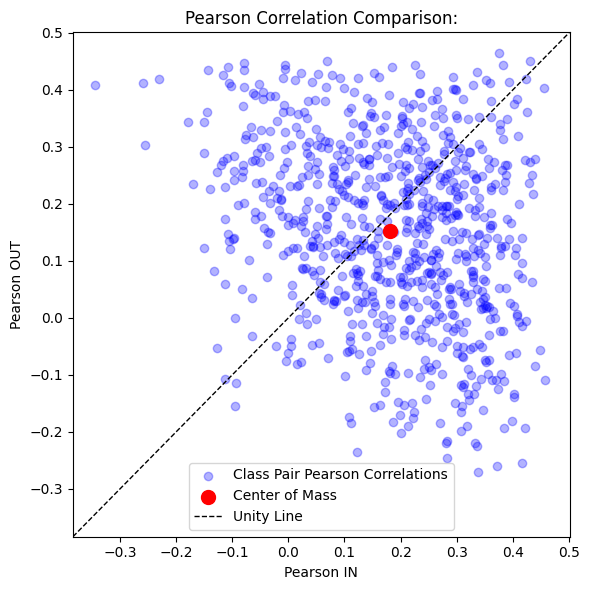

t-statistic: 3.496, p-value: 0.0004991


In [43]:
p_lal = [
    pearson_values[cl][cr]['left_attleft'][0]
    for cl in classes_left for cr in classes_right
    if pearson_values[cl][cr]['left_attleft']
]
p_ral = [
    pearson_values[cl][cr]['right_attleft'][0]
    for cl in classes_left for cr in classes_right
    if pearson_values[cl][cr]['right_attleft']
]
p_lar = [
    pearson_values[cl][cr]['left_attright'][0]
    for cl in classes_left for cr in classes_right
    if pearson_values[cl][cr]['left_attright']
]
p_rar = [
    pearson_values[cl][cr]['right_attright'][0]
    for cl in classes_left for cr in classes_right
    if pearson_values[cl][cr]['right_attright']]

pearson_in = np.array(p_lal + p_rar) / 2
pearson_out = np.array(p_ral + p_lar) / 2
                

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot for left_attleft vs right_attleft
ax.scatter(pearson_in, pearson_out, alpha=0.3, label='Class Pair Pearson Correlations', color='blue')

#plotting center of mass
mean_in = np.mean(pearson_in)
mean_out = np.mean(pearson_out)
ax.scatter(mean_in, mean_out, color='red', label='Center of Mass', s=100)


# Unity line
lims = [

    np.min([ax.get_xlim()[0], ax.get_ylim()[0]]),
    np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
]
ax.plot(lims, lims, linestyle='--', linewidth=1, label='Unity Line', color='black')

# Set axis limits and labels
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Pearson IN')
ax.set_ylabel('Pearson OUT')
ax.set_title('Pearson Correlation Comparison:')
ax.legend()
plt.tight_layout()
plt.show()

#ttest on in vs out condition
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(pearson_in, pearson_out)
print(f"t-statistic: {t_stat:.4}, p-value: {p_value:.4}")

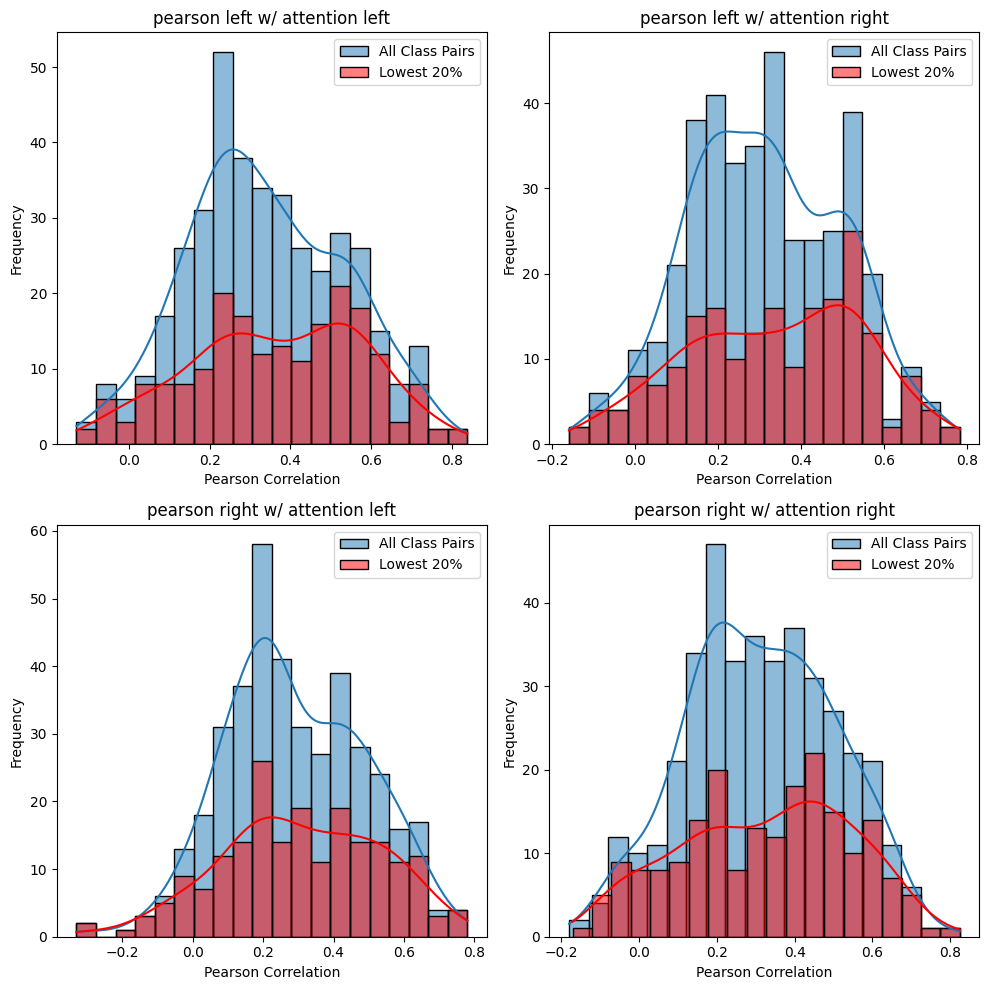

In [ ]:
#==============================histograms================================
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the extracted wSMI values into 1D lists before plotting
hist_values_all = [results_to_plot[cl][cr]['left_attleft']
                      for cl in classes_left for cr in classes_right]
hist_values_low = [results_to_plot_low[cl][cr]['left_attleft']
                      for cl in classes_left for cr in classes_right if results_to_plot_low[cl][cr]['left_attleft'] != -1]

sns.histplot(hist_values_all, ax=ax[0, 0], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[0, 0], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[0,0].set_title('pearson left w/ attention left')
ax[0,0].set_xlabel('Pearson Correlation')
ax[0,0].set_ylabel('Frequency')
ax[0,0].legend()

# Repeat for the other plots
hist_values_all = [results_to_plot[cl][cr]['right_attleft']
                      for cl in classes_left for cr in classes_right]
hist_values_low = [results_to_plot_low[cl][cr]['right_attleft']
                      for cl in classes_left for cr in classes_right if results_to_plot_low[cl][cr]['right_attleft'] != -1]

sns.histplot(hist_values_all, ax=ax[1, 0], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[1, 0], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[1,0].set_title('pearson right w/ attention left')
ax[1,0].set_xlabel('Pearson Correlation')
ax[1,0].set_ylabel('Frequency')
ax[1,0].legend()

hist_values_all = [results_to_plot[cl][cr]['left_attright']
                      for cl in classes_left for cr in classes_right]
hist_values_low = [results_to_plot_low[cl][cr]['left_attright']
                      for cl in classes_left for cr in classes_right if results_to_plot_low[cl][cr]['left_attright'] != -1]

sns.histplot(hist_values_all, ax=ax[0, 1], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[0, 1], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[0,1].set_title('pearson left w/ attention right')
ax[0,1].set_xlabel('Pearson Correlation')
ax[0,1].set_ylabel('Frequency')
ax[0,1].legend()

hist_values_all = [results_to_plot[cl][cr]['right_attright']
                      for cl in classes_left for cr in classes_right]
hist_values_low = [results_to_plot_low[cl][cr]['right_attright']
                      for cl in classes_left for cr in classes_right if results_to_plot_low[cl][cr]['right_attright'] != -1]

sns.histplot(hist_values_all, ax=ax[1, 1], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[1, 1], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[1,1].set_title('pearson right w/ attention right')
ax[1,1].set_xlabel('Pearson Correlation')
ax[1,1].set_ylabel('Frequency')
ax[1,1].legend()

plt.tight_layout()
plt.show()